Test of the RedPitaya with QCodes drivers

In [1]:
import sys, os
import time
import numpy as np

import qcodes as qc
from qcodes import validators as vals
from qcodes.instrument import ( Instrument,
                                InstrumentChannel,
                                InstrumentModule,
                                ManualParameter,
                                MultiParameter,
                                VisaInstrument,
                                )

from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter

In [2]:
# redpitaya drivers
sys.path.append(r'C:\Users\nicol\Open Haloscope')
from red.redpitaya_qcodes import Redpitaya

<h4>Setpoints</h4>

<h4>Test of the drivers</h4>

In [3]:
red = Redpitaya('redpitaya', address='TCPIP::192.168.1.30::5000::SOCKET')

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.27s


In [4]:
red.OUT1_amplitude(0.2)
red.OUT1_frequency(1e6)
red.OUT1_status('ON')

red.OUT2_amplitude(0.1)
red.OUT2_frequency(2e6)
red.OUT2_status('ON')

In [5]:
red.ADC_trigger_level(0)
red.align_channels_phase()
red.trigger_channels()

red.ADC_start()
time.sleep(0.1)
red.ADC_stop()

In [6]:
data_string_1 = np.array( red.IN1_read_buffer()[1:-1].split(',') )
data_1 = data_string_1.astype(float)

data_string_2 = np.array( red.IN2_read_buffer()[1:-1].split(',') )
data_2 = data_string_2.astype(float)

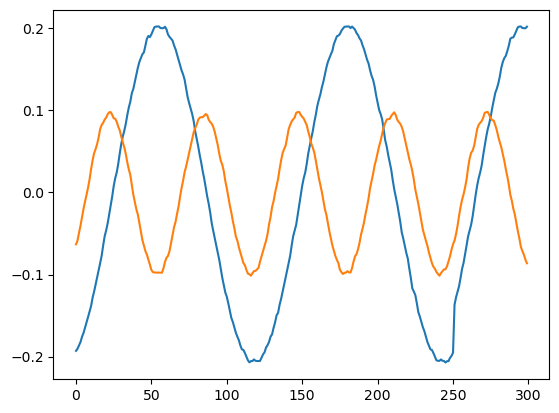

In [7]:
import matplotlib.pyplot as plt
plt.plot( data_1[0:300] )
plt.plot( data_2[0:300] )

In [8]:
red.IN1_waveform()

array([0.43487317, 0.32424464, 0.29599022, ..., 0.19515495, 0.91036745,
       0.99642664])

In [9]:
class Oscilloscope():
    
    
    FS = 125000000.0             # sampling frequency
    DW = 16                      # register width - linear addition multiplication
    _DWr  = (1 << (DW-1)) - 1    # fixed point range
    
    # buffer parameters
    buffer_size = 2**14          # buffer size
    CW = 31                      # counter size
    _CWr = 2**CW                 # twice the counter size

    ranges = (1.0, 20.0)          # analog stage range voltages
    

    def data(self, size: int = buffer_size, ptr: int = None) -> np.array:
        """Data.
        Parameters
        ----------
        siz : int, optional
            Number of data samples to be read from the FPGA buffer.
        ptr : int, optional
            End of data pointer, only use if you understand
            the source code.
        Returns
        -------
        array
            Array containing float samples scaled
            to the selected analog range.
            The data is alligned at the end to the last sample
            stored into the buffer.
        """
        if ptr is None:
            ptr = int(self.pointer)
            
        adr = (self.buffer_size + ptr - size) % self.buffer_size
        scale = self.__input_range / float(self._DWr)
        
        # TODO: avoid making copy of entire array
        wave = np.roll(self.buffer, -ptr)
        
        return (wave.astype('float32')[-size:] * scale)
    